In [1]:
import numpy as np
import librosa as lb
from matplotlib import pyplot as plt
import os
from IPython.display import Audio
import scipy

Function definations for easier programming

In [2]:
def fft_plot(audio, sampling_rate, scale= 'log'):
    n = len(audio)
    n_FFT= scipy.fft.next_fast_len(n)
    # print(f'n-points in fft = {n_FFT}') #debug
    T= 1/sampling_rate
    yf = scipy.fftpack.fft(audio, n= n_FFT)
    # xf = np.linspace(0, 1/(2*T), n//2)
    freq = scipy.fftpack.fftfreq(n, d= T)
    plt.yscale(scale)
    plt.plot(freq[:n_FFT//2],  2/n_FFT* np.abs(yf[:n_FFT//2])) #2/n
    plt.grid()
    plt.xlabel('Frequency(in Hz)')
    plt.ylabel(f'{scale} Magnitude')
    # return plt.show()

In [3]:
def getFrames(y, sr,  frameLength, hopLength): 
    #frameLength and hopLength in ms
    # duration = len(y)*(1/sr) #in seconds
    # nframeLength = int(duration/(frameLength*0.001))# ms to n
    # nhopLength = int(duration/(hopLength*0.001))# ms to n
    nframeLength = int(frameLength*0.001*sr)
    nhopLength = int(hopLength*0.001*sr)
    return lb.util.frame(y, frame_length=nframeLength, hop_length=nhopLength, axis= 0)

In [4]:
def visualizeAudio(y, sr_native, fileName= 'Audio'):
    # to visualize the waveform
    duration = len(y)/sr_native #in seconds
    timeScale = np.linspace(0,duration, len(y))
    plt.plot(timeScale, y)
    plt.xlabel('Time(in secs)')
    plt.ylabel('Audio amplitute')
    plt.title(fileName)
    plt.grid(True)

In [224]:
def getVoicedFramesZCR(y, sr, frameLength, hopLength):
    frameIndex = []
    nframeLength = int(frameLength*0.001*sr)
    nhopLength = int(hopLength*0.001*sr)
    zcr = lb.feature.zero_crossing_rate(y, frame_length=nframeLength, hop_length=nhopLength)
    # print(zcr)
    for i, rate in enumerate(zcr[0]):
        if rate > 0.001:
            frameIndex.append(i)
    return frameIndex

In [186]:
def getVoicedFrames(frames, energyThreshold = 10):
    nframeLength = len(frames[0])
    hwin = scipy.signal.get_window('hamming', nframeLength)
    #getting energy of each frame
    energyVector = []
    frameIndex = []
    for aframe in frames:
        energyVector.append(np.dot(aframe*hwin, aframe*hwin))

    # selecting threshold
    
    # plt.plot(energyVector)
    # geting voiced frames
    voicedFrames = []
    for i, energy in enumerate(energyVector):
        if energy > energyThreshold:
            frameIndex.append(i)
            voicedFrames.append(frames[i])
    return np.array(voicedFrames), frameIndex

In [6]:
def clippingFn(frame, threshold_percent):
    clippedFrame = []
    threshold = np.max(frame)*threshold_percent
    for i_data in frame:
        if i_data > threshold:
            clippedFrame.append(i_data - threshold)
        elif i_data < -threshold:
            clippedFrame.append(i_data + threshold)
        else:
            clippedFrame.append(0)
    return np.array(clippedFrame)

Importing audio file and pre-processing

In [7]:
# importing the filenames in directory
path = 'F:\\Python@IITMandi\\Programming practicum project work\\arctic-20221111T144309Z-001\\arctic\\'
fileNames = os.listdir(path)
fileNames
AudioFileMenu = ''
for i, name in enumerate(fileNames):
    if name.endswith('wav'):
        AudioFileMenu = AudioFileMenu + f'{i}. {name}\n'

In [8]:
# importing the audiofile
audioSelection = int(input(AudioFileMenu))
audioData, sr_native = lb.load(path+fileNames[audioSelection], sr = None, mono=False)
y = audioData[0] # audio data
egg = audioData[1] #EGG data
print(f'Sampling rate = {sr_native}')

Sampling rate = 32000


Visualisation of said audio data

In [9]:
# to play the audio file using widget
Audio(data=y, rate=sr_native)

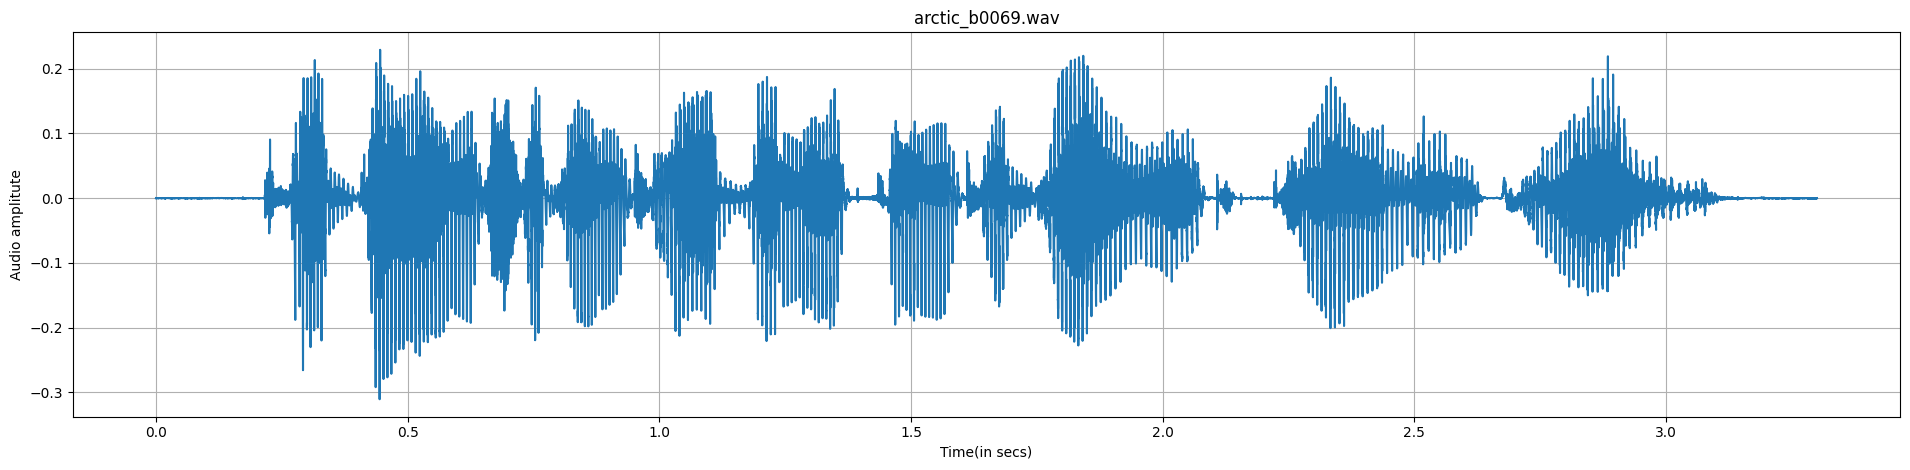

In [150]:
plt.figure()
visualizeAudio(y, sr_native, fileNames[audioSelection])
plt.tight_layout(rect = [0, 0, 3, 1])
plt.show()

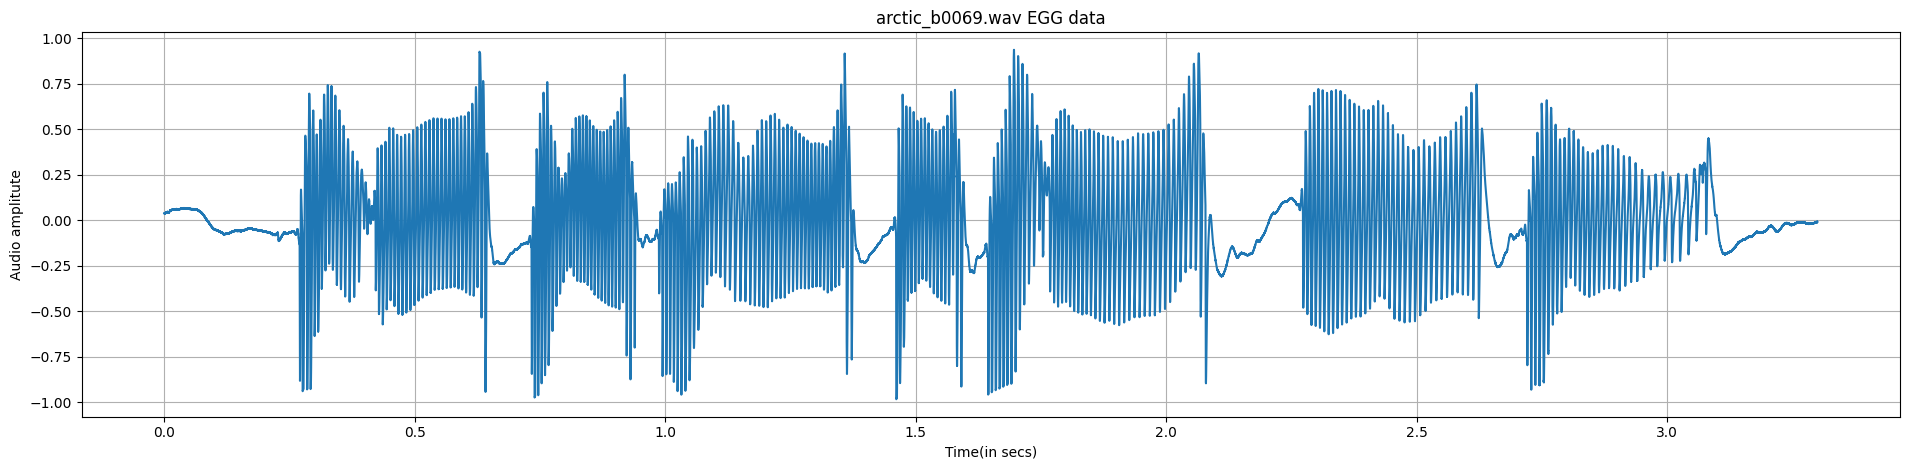

In [151]:
plt.figure()
visualizeAudio(egg, sr_native, fileNames[audioSelection] + ' EGG data')
plt.tight_layout(rect = [0, 0, 3, 1])
plt.show()

Segmenting into frames

In [152]:
frameLength, hopLength = 30, 15 # in ms
frames = getFrames(y, sr_native, frameLength, hopLength)
eggFrames = getFrames(egg, sr_native, frameLength, hopLength)

Checking frames and their spectrum

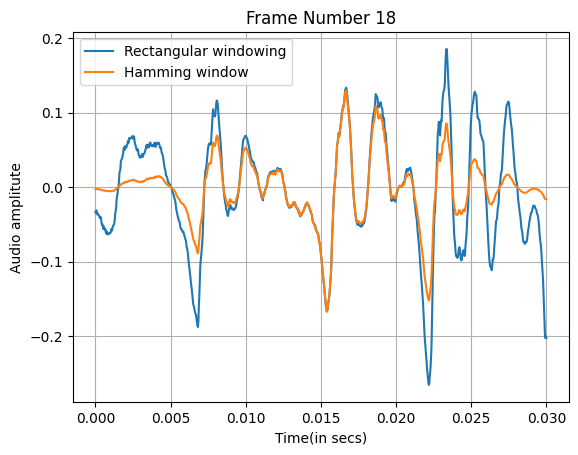

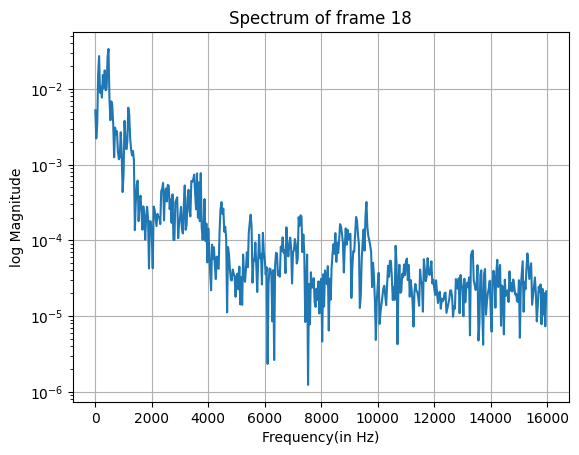

In [153]:
frameNumber = 18

nframeLength = int(frameLength*0.001*sr_native)# ms to n
hwin = scipy.signal.get_window('hamming', nframeLength)
visualizeAudio(frames[frameNumber], sr_native, f'Frame number {frameNumber}') # rectangular windowed frame
visualizeAudio(hwin*frames[frameNumber], sr_native, f'Frame Number {frameNumber}') # hamming windowed frame
plt.legend(['Rectangular windowing', 'Hamming window'])
plt.show()

plt.title(f'Spectrum of frame {frameNumber}')
# fft_plot(frames[frameNumber], sr_native, scale='log')
fft_plot(hwin*frames[frameNumber], sr_native, scale='log')
plt.show()


In [154]:
#frame number to time
lb.time_to_frames(0.5, sr=sr_native, hop_length=hopLength*0.001*sr_native)
# lb.frames_to_time(58, sr=sr_native, hop_length=hopLength*0.001*sr_native)

33

Seperating voiced frames from the segments

In [205]:
# voicedEGGFrames, frameIndex = getVoicedFrames(frames=eggFrames, energyThreshold=6)
# # plt.grid()
# # plt.tight_layout(rect= [0, 0, 3, 1])
# voicedFrames = [f for i, f in enumerate(frames) if i in frameIndex]

In [225]:
voicedFrameIndices = getVoicedFramesZCR(y=egg, sr=sr_native, frameLength=30, hopLength=15)
# plt.grid()
# plt.tight_layout(rect= [0, 0, 3, 1])
voicedFrames = [f for i, f in enumerate(frames) if i in voicedFrameIndices]
voicedEGGFrames = [f for i, f in enumerate(eggFrames) if i in voicedFrameIndices]


In [226]:
print(f'Indices of voiced frames = {voicedFrameIndices}')
len(voicedFrames)

Indices of voiced frames = [5, 6, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 147, 148, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207]


171

Pitch estimation using autocorelation on clipped signal

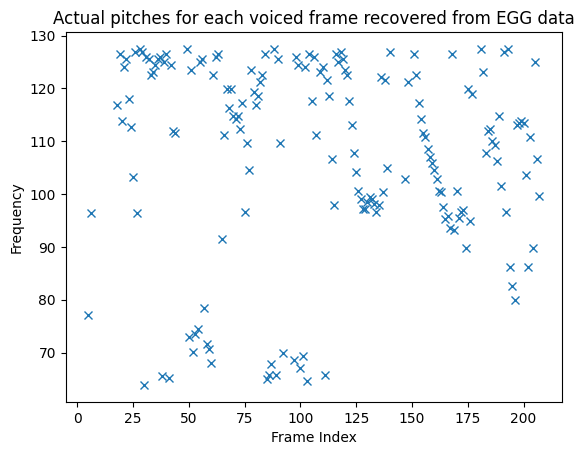

In [263]:
#determining the actual pitches from the egg signal frames
actual_pitches = []
# index = 0 # debug
#human voice between 85Hz - 255Hz
min_distance_bw_peaks = sr_native/255
max_distance_bw_peaks = sr_native/255
for f in voicedEGGFrames:
    # index += 1 # debug
    fDiff = -np.diff(f)
    # plt.plot(f)
    # plt.figure()
    # plt.plot(fDiff)
    peaks, properties= scipy.signal.find_peaks(fDiff, distance=2*min_distance_bw_peaks) #this works so don't disturb
    # plt.plot(peaks, fDiff[peaks], 'o')
    n_period = np.diff(peaks)[0]
    pitch_freq = sr_native/n_period
    actual_pitches.append(pitch_freq)
plt.figure()
plt.title('Actual pitches for each voiced frame recovered from EGG data')
plt.plot(voicedFrameIndices, actual_pitches, 'x')
plt.xlabel('Frame Index')
plt.ylabel('Frequency')
plt.show()

In [285]:
estimated_pitches = []
index = 0
for f in voicedFrames:
    index += 1
    clipped_f = clippingFn(f, threshold_percent = 0.5)
    corr = scipy.signal.correlate(clipped_f, clipped_f)[len(clipped_f):]
    peaks, properties= scipy.signal.find_peaks(corr, distance=2*min_distance_bw_peaks, ) #this works so don't disturb
    # plt.plot(corr)
    # plt.plot(peaks, corr[peaks], '+')
    try:
        n_period = np.diff(peaks)[0]
    except:
        n_period = 2*min_distance_bw_peaks
    pitch_freq = sr_native/n_period
    estimated_pitches.append(pitch_freq)


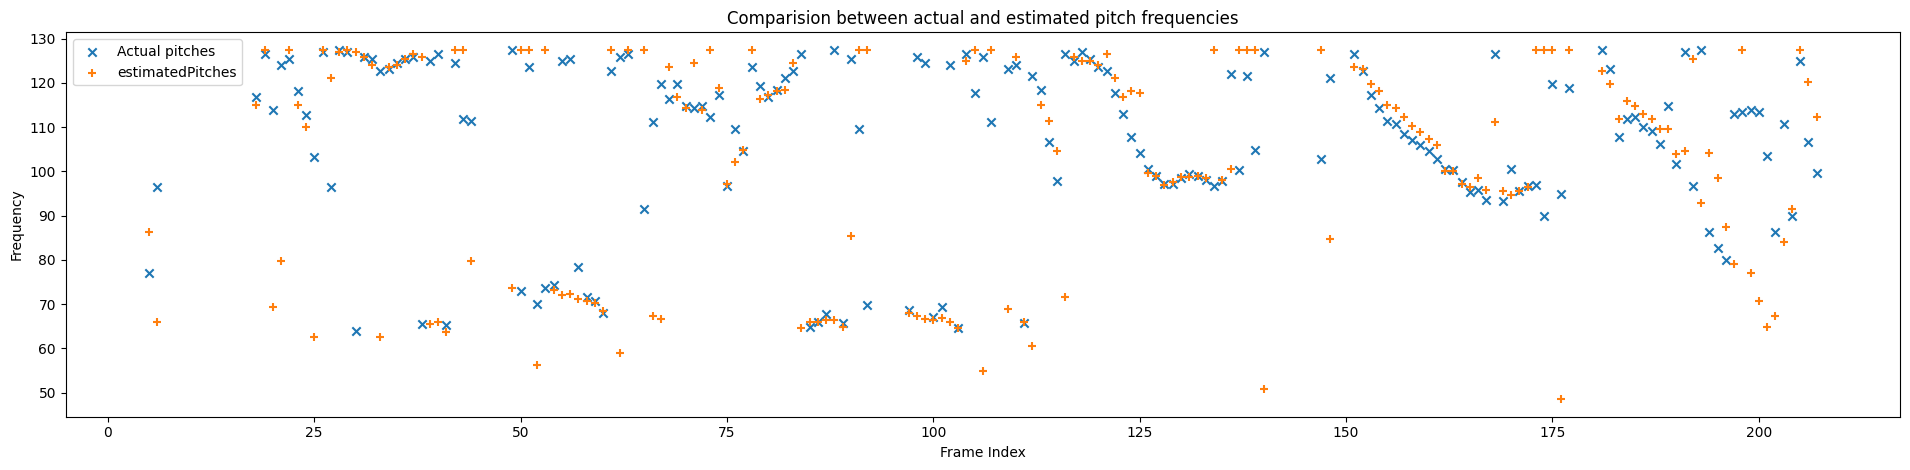

In [289]:
plt.figure()
plt.title('Comparision between actual and estimated pitch frequencies')
plt.scatter(voicedFrameIndices[:], actual_pitches[:], marker='x', label = 'Actual pitches')
plt.scatter(voicedFrameIndices[:], estimated_pitches[:], marker= '+', label = 'estimatedPitches')
plt.xlabel('Frame Index')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout(rect=[0, 0, 3, 1])
plt.show()

In [278]:
err = np.array(actual_pitches)-np.array(estimated_pitches)
np.mean(err**2)

686.6983749935386

In [172]:
index, len(voicedFrames)

(154, 187)